1. Collect Images and Annotate

In [1]:
!pip install labelme
!pip install tensorflow
!pip install opencv-python
!pip install albumentations
!pip install matplotlib
!pip uninstall -y opencv-python-headless
!pip uninstall -y opencv-python
!pip install opencv-python

  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84
Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Successfully uninstalled opencv-python-4.10.0.84
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)


In [14]:
import os
import uuid
import time
import cv2

In [20]:
imPath = os.path.join('data', 'images')
imageNum = 20

#Establish connection to video camera
# Changed camera index to 0
ImageCapture = cv2.VideoCapture(0)

# Check if camera opened successfully
if not ImageCapture.isOpened():
    print("Error opening video stream or file")
    exit()

for image in range(imageNum):
    print('Image Collection Processing..'.format(image))
    #read from capture device/camera then write
    ret, frame = ImageCapture.read()

    # Check if frame is read correctly
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    nameImage = os.path.join(imPath, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(nameImage, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('x'):
        break
ImageCapture.release()
cv2.destroyAllWindows()

  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84
Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Successfully uninstalled opencv-python-4.10.0.84
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Image Collection Processing..
Can't receive frame (stream end?). Exiting ...


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [7]:
!labelme

2024-12-06 19:22:27,485 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\rpat2\.labelmerc


2. Build Image Loading Function

In [1]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [86]:
images = None

In [88]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False) # Load images into TF Data Pipeline

In [90]:
images.as_numpy_iterator().next() # Should display path and name of next image

b'data\\images\\00d9ad54-3b27-465d-9ad2-490798640bd2.jpg'

In [92]:
# Read in image and output pixel values
def load_image(path): 
    encoded_byte = tf.io.read_file(path)
    image = tf.io.decode_jpeg(encoded_byte)
    return image

In [94]:
images = images.map(load_image) # Run function for all images in pipeline

3. Partition Unaugmented Data

In [97]:
# 70% training, 15% testing, 15% validation

# Find the matching label for the image and insert into the labels folder
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        name = file.split('.')[0]+'.json'
        path = os.path.join('data','labels', name)
        if os.path.exists(path): 
            new_path = os.path.join('data',folder,'labels', name)
            os.replace(path, new_path)  

4. Apply Image Augmentation

In [100]:
import albumentations as alb

In [102]:
# Augmentation Pipeline - Apply differnet transformations
augmentor = alb.Compose([alb.RandomCrop(width=400, height=400), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.VerticalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.3),
                         alb.RandomGamma(p=0.3), 
                         alb.RGBShift(p=0.3)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['classes']))

In [104]:
# Load test image
img = cv2.imread(os.path.join('data','train', 'images','00d9ad54-3b27-465d-9ad2-490798640bd2.jpg'))

In [106]:
# Load test annotation
with open(os.path.join('data', 'train', 'labels', '00d9ad54-3b27-465d-9ad2-490798640bd2.json'), 'r') as f:
    label = json.load(f)

In [108]:
label['shapes']

[{'label': 'Raj',
  'points': [[247.5, 175.0], [366.38888888888886, 340.55555555555554]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None}]

In [110]:
# Store bboxes and class label for image
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [112]:
coords = list(np.divide(coords, [640,480,640,480]))

In [114]:
coords

[0.38671875, 0.3645833333333333, 0.5724826388888888, 0.7094907407407407]

In [116]:
classes =['Raj']

In [118]:
# Apply augmentations
augmented = augmentor(image=img, bboxes=[coords], classes=classes) # class label -----------------------------------------------

In [120]:
augmented

{'image': array([[[ 87, 105,  93],
         [ 87, 105,  93],
         [ 87, 105,  93],
         ...,
         [168, 185, 171],
         [167, 183, 170],
         [165, 181, 168]],
 
        [[ 87, 105,  92],
         [ 87, 105,  92],
         [ 87, 105,  92],
         ...,
         [166, 182, 169],
         [163, 180, 166],
         [162, 178, 165]],
 
        [[ 87, 105,  92],
         [ 87, 105,  92],
         [ 87, 105,  92],
         ...,
         [163, 179, 166],
         [161, 177, 164],
         [159, 176, 162]],
 
        ...,
 
        [[ 44,  69,  59],
         [ 45,  71,  61],
         [ 49,  73,  65],
         ...,
         [ 92, 110,  97],
         [ 92, 109,  96],
         [ 91, 109,  95]],
 
        [[ 43,  68,  58],
         [ 45,  70,  60],
         [ 48,  73,  63],
         ...,
         [ 92, 110,  97],
         [ 92, 109,  96],
         [ 90, 108,  94]],
 
        [[ 45,  70,  60],
         [ 45,  71,  61],
         [ 46,  72,  61],
         ...,
         [ 92, 110,

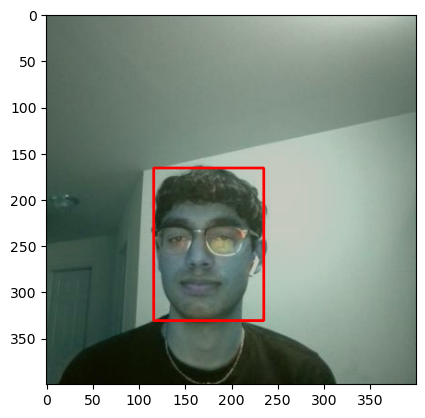

In [122]:
# Draw bounding box around augmented image
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [400,400]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [400,400]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

5. Build and Run Augmentation Pipeline

In [125]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            # augment 25 images for every images in dataset
            for x in range(25):
                augmented = augmentor(image=img, bboxes=[coords], classes=['Raj'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [3.74441952e-01 7.06128776e-01 0.00000000e+00 6.61375641e-04
 0.00000000e+00].
x_max is less than or equal to x_min for bbox [0.23245288 0.8075397  0.00117808 0.01940035 0.        ].
y_max is less than or equal to y_min for bbox [0.0053681  0.89877301 0.1961273  0.3133947  0.        ].
y_max is less than or equal to y_min for bbox [0.13381901 0.54089981 0.51246166 0.00153374 0.        ].
y_max is less than or equal to y_min for bbox [0.09835123 0.8438139  0.4482362  0.01175869 0.        ].
x_max is less than or equal to x_min for bbox [ 3.64521325e-01  6.04717791e-01 -5.92118977e-17  1.35061536e-02
  0.00000000e+00].
x_max is less than or equal to x_min for bbox [0.3266989  0.98500884 0.00179812 0.34016755 0.        ].
x_max is less than or equal to x_min for bbox [1.24565974e-01 9.93827164e-01 2.96059489e-17 4.47725624e-01
 0.00000000e+00].


In [127]:
train_images = None
test_images = None
val_images = None

In [129]:
# Load augmented images to the TensorFlow data pipeline
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [131]:
train_images.as_numpy_iterator().next()

array([[[0.46209148, 0.46405226, 0.3614379 ],
        [0.45555556, 0.46732026, 0.3614379 ],
        [0.44880173, 0.464488  , 0.35860565],
        ...,
        [0.21339779, 0.24999902, 0.24411678],
        [0.08627451, 0.13725491, 0.10588235],
        [0.04139468, 0.09237507, 0.05315939]],

       [[0.4633987 , 0.46535948, 0.3627451 ],
        [0.45686275, 0.46862745, 0.3627451 ],
        [0.45294118, 0.46862745, 0.3627451 ],
        ...,
        [0.7297413 , 0.76242095, 0.76830345],
        [0.04313726, 0.09411765, 0.06666667],
        [0.04379117, 0.09477156, 0.05620955]],

       [[0.46263617, 0.46459696, 0.36198258],
        [0.45392156, 0.46568626, 0.35980392],
        [0.4553377 , 0.47102398, 0.36514163],
        ...,
        [0.29880437, 0.3354056 , 0.32298744],
        [0.07058824, 0.12156863, 0.08529413],
        [0.05838767, 0.11263604, 0.06361642]],

       ...,

       [[0.34956425, 0.3654684 , 0.23594771],
        [0.3611111 , 0.37679738, 0.2473856 ],
        [0.3674292 , 0

6. Prepare Labels

In [134]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [136]:
train_labels = None
test_labels = None
val_labels = None

In [138]:
# Store labels
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [140]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.6416, 0.311 , 0.939 , 0.725 ], dtype=float16))

7. Combine Label and Image Samples

In [143]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels) # partition lengths 

(2220, 2220, 490, 490, 460, 460)

In [690]:
train = None
test = None
val = None

In [145]:
# Combine images and labels into one (final dataset)
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(2500)
train = train.batch(8)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(500)
test = test.batch(8)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(500)
val = val.batch(8)
val = val.prefetch(4)

In [153]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.1969 , 0.03775, 0.679  , 0.85   ],
        [0.455  , 0.1211 , 0.819  , 0.624  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.4377 , 0.0171 , 1.     , 0.8467 ],
        [0.1562 , 0.1881 , 0.4688 , 0.6396 ],
        [0.05618, 0.     , 0.608  , 0.864  ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

In [161]:
data_samples = train.as_numpy_iterator()

In [163]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


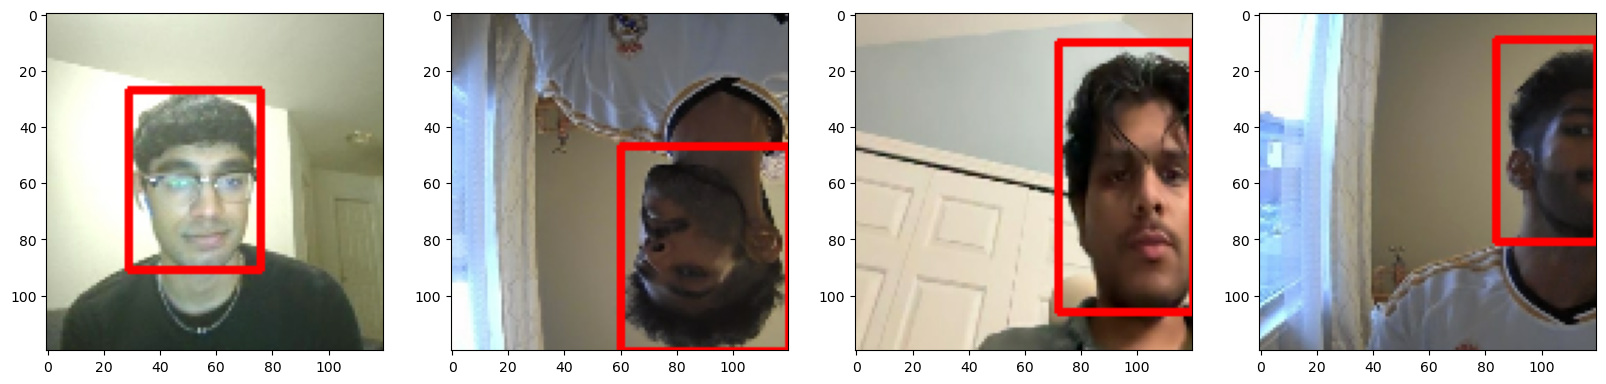

In [164]:
# View sample annotations
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    sample_image_copy = sample_image.copy()
    
    cv2.rectangle(sample_image_copy, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image_copy)

8. Build Deep Learning Model

In [168]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [170]:
vgg = VGG16(include_top=False)

In [172]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [174]:
def build_model(): 
    input_layer = Input(shape=(120,120,3)) # Declare input (120x120 image)
    
    vgg = VGG16(include_top=False)(input_layer) # Pass input through vgg

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)  
    
    # Bounding Box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1) # 4 outputs for regression
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2]) # Classification and regression output
    return facetracker

In [176]:
facetracker = build_model()

In [178]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 120, 120, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 3, 3, 512)         │      14,714,688 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d          │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_1        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 2048)              │       1,050,624 │ global_max_pooling2d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           2,049 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 4)                 │           8,196 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [180]:
X, y = train.as_numpy_iterator().next() # X=image, y=label

In [181]:
X.shape

(8, 120, 120, 3)

In [184]:
classes, coords = facetracker.predict(X) # Test initial model (before training)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


In [186]:
classes, coords

(array([[0.5582986 ],
        [0.6081437 ],
        [0.5396695 ],
        [0.6136502 ],
        [0.5038508 ],
        [0.5803642 ],
        [0.47724813],
        [0.5371293 ]], dtype=float32),
 array([[0.7972013 , 0.2653112 , 0.5435236 , 0.50788885],
        [0.64467406, 0.3541695 , 0.5842576 , 0.5152949 ],
        [0.60462654, 0.38384593, 0.57915497, 0.59147716],
        [0.7747571 , 0.3393051 , 0.59258586, 0.5629776 ],
        [0.620697  , 0.38012114, 0.48852506, 0.6573843 ],
        [0.7141421 , 0.46894413, 0.593277  , 0.49732053],
        [0.67684186, 0.40986532, 0.534111  , 0.6049206 ],
        [0.68114734, 0.39294687, 0.46672076, 0.60867816]], dtype=float32))

9. Define Losses and Optimizers

In [189]:
batches_per_epoch = len(train) # 70%
lr_decay = (1./0.75 -1)/batches_per_epoch

In [191]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay) # optimzer

C:\Users\rpat2\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [193]:
# Function to calculate localization error
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [195]:
# Store errors/losses
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [197]:
localization_loss(y[1], coords).numpy() # Test function

7.073111

In [199]:
classloss(y[0], classes).numpy()

0.69249105

In [201]:
regressloss(y[1], coords).numpy()

7.073111

10. Train Neural Network

In [204]:
# Class for the training model 
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    # loss and optimizers
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    # train neural network
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        y[0].set_shape([None,1])  
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    # test model
    def test_step(self, batch, **kwargs): 
        X, y = batch
        y[0].set_shape([None,1])  
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [206]:
model = FaceTracker(facetracker) # Pass through neural network 

In [208]:
model.compile(opt, classloss, regressloss)

In [210]:
logdir='logs'

In [212]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [214]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback]) # train

Epoch 1/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 277s 952ms/step - class_loss: 0.2015 - regress_loss: 0.7722 - total_loss: 0.8729 - val_total_loss: 0.1125 - val_class_loss: 0.0024 - val_regress_loss: 0.1113
Epoch 2/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - class_loss: 0.1037 - regress_loss: 0.3620 - total_loss: 0.4138 - val_total_loss: 0.0893 - val_class_loss: 0.0183 - val_regress_loss: 0.0802
Epoch 3/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 262s 937ms/step - class_loss: 0.0767 - regress_loss: 0.2438 - total_loss: 0.2821 - val_total_loss: 0.1121 - val_class_loss: 0.0331 - val_regress_loss: 0.0955
Epoch 4/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - class_loss: 0.0489 - regress_loss: 0.1885 - total_loss: 0.2129 - val_total_loss: 0.0716 - val_class_loss: 0.0414 - val_regress_loss: 0.0509
Epoch 5/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 270s 964ms/step - class_loss: 0.0433 - regress_loss: 0.1642 - total_loss: 0.1859 - val_total_loss: 0.0165 - val_class_loss: 3.6278e-04 - val_regress_loss: 0.0163
Epoch 6/15
2

In [918]:
hist.history

{'total_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.10296224802732468>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.02256251871585846>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.052308227866888046>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.05844884738326073>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.02791360393166542>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.011670385487377644>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.013437625020742416>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0137149877846241>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.005748322233557701>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.009123587049543858>],
 'class_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0005223372718319297>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.00038235518150031567>,
  <tf.Tensor: shape=(), dtype=float32, numpy=8.099222554847074e-07>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.01396202016621828>,
  <tf.Tensor: shape=()

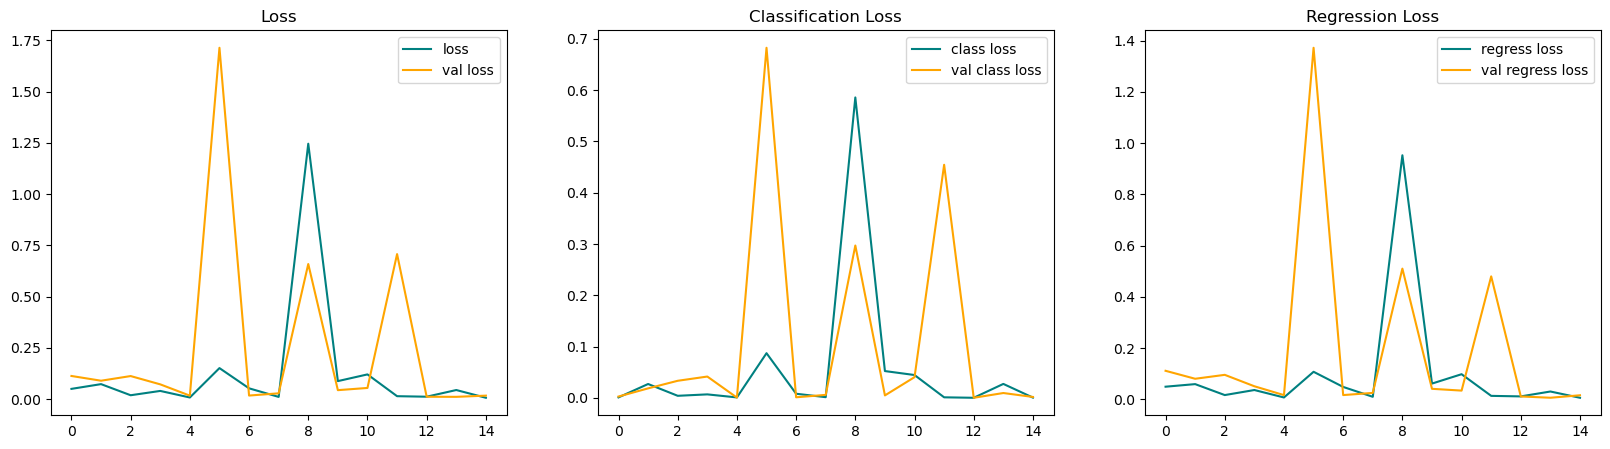

In [216]:
# Plot performance
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

11. Make Predictions

In [266]:
test_data = test.as_numpy_iterator()

In [267]:
test_sample = test_data.next()

In [269]:
yhat = facetracker.predict(test_sample[0]) # Run prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


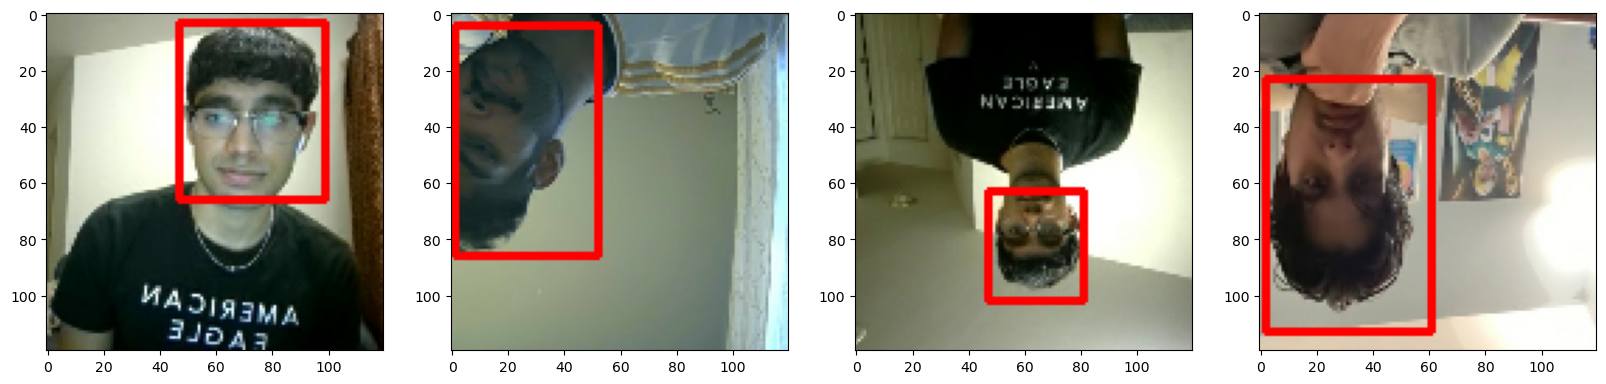

In [270]:
# See predictions
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        sample_image_copy = sample_image.copy()
        cv2.rectangle(sample_image_copy, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image_copy)

In [274]:
from tensorflow.keras.models import load_model

In [276]:
facetracker.save('me_facetracker.h5')

In [278]:
facetracker = load_model('me_facetracker.h5')

In [280]:
# Real-Time Detection
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [400,400]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [400,400]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [400,400]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [400,400]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Raj', tuple(np.add(np.multiply(sample_coords[:2], [400,400]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceDetection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
